In [ ]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import seaborn as sns
from pandas_profiling import ProfileReport

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Netflix Analysis Report | EDA Guidelines 📊</p>



<p style="font-family:newtimeroman; font-size:200%; text-align:center;"><b>This kernel is part of a Plotly guide that I am developing at the moment and it's focused showing the main tips and tricks for the Data Analysis.</b></p>
<p style="font-family:newtimeroman; font-size:150%; text-align:center;"><i><a href='https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly'>Part I: Netflix Analysis (this one)</a></i></p>

<p style="font-family:newtimeroman; font-size:150%; text-align:center;"><i><a href='https://www.kaggle.com/andreshg/video-games-eda-and-visualization'>Part II: Video Games Analysis</a></i></p>

<p style="font-family:newtimeroman; font-size:150%; text-align:center;"><i><a href='https://www.kaggle.com/andreshg/covid-progression-a-plotly-animated-guide'>Part III: COVID-19 World Vaccination Progress</a></i></p>

The main idea of this notebook is to show how to make and EDA job focusiong on different types of plots and chartes. I want to focus this notebook on interative plots with Plotly. I think that other libraries like seaborn and awesome and absolutely necesary for any Data Scientist job, but in this case i want to show interative plots. I will focus on other libraries in other tutorials.

So here you can see how to extract information from a dataset and how to plot.

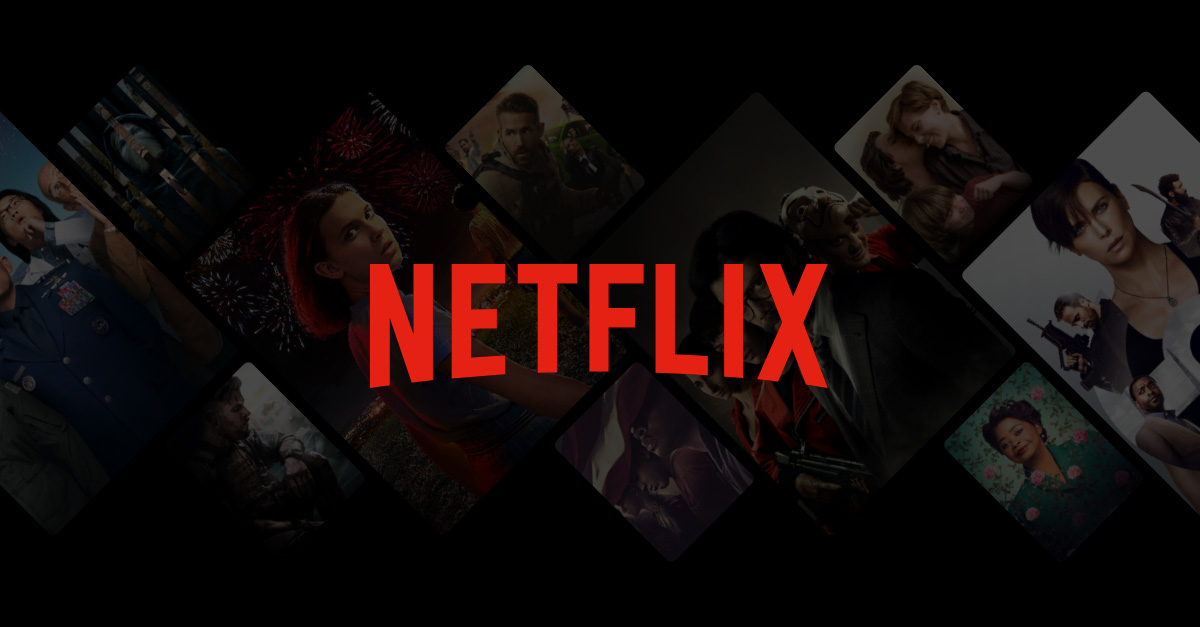

In [ ]:
df = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
df.head()

In [ ]:
df.info()

In [ ]:
report = ProfileReport(df)

In [ ]:
report

# Data Cleaning

Lets check how many nulls are there in the data

In [ ]:
df.nunique()

In [ ]:
df.isna().sum()

The missing values are in:
* `director`: i think its not needed for the analysis (no much information)
* `cast`: this var has too many diferent values too so there is no muich information out there 
* `country`: this is a importante variable so wi will think how to fix it (maybe mode)
* `date_added`: there are just a few cases, so lets scrap them
* `rating`: there are just a few cases, so lets scrap them

### Fix rating missings

In [ ]:
df['rating'].unique()

In [ ]:
df[df['rating'].isna()]

Based on the information from [Amazon](https://www.amazon.com/gp/help/customer/display.html?nodeId=G2C2CPZWGZWHZ42J) ranting information and Netflix shows, we can find the following replacements

In [ ]:
rating_replacements = {
    211: 'TV-14',
    2411: 'TV-14',
    3288: 'PG-13',
    4056: 'TV-G',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-14',
    5234: 'TV-14',
    6231: 'TV-Y'
}

for id, rate in rating_replacements.items():
    df.iloc[id, 8] = rate
    
df['rating'].isna().sum()

### Drop director and cast columns

In [ ]:
df = df.drop(['director', 'cast'], axis=1)
df.columns

### Fix date_added missings 

In [ ]:
df[df['date_added'].isna()]

I have search for them in the internet and is dificult to find the `date_added`to Netlix, so i will drop them, as they are only 11 rows

In [ ]:
df = df[df['date_added'].notna()]

### Fix country missing values

In [ ]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

### Check if data is cleaned

In [ ]:
df.isna().sum()

## Generate new columns based on variables

In [ ]:
df.head()

### Year and month by adding date

We are going to take the year and the month from `date_added` so we can compare wich are the most valueable months and the difference between Show realse and Netflix adding dates

In [ ]:
df['year_added'] = df['date_added'].apply(lambda x: x.split(" ")[-1])
df['year_added'].head()

In [ ]:
df['month_added'] = df['date_added'].apply(lambda x: x.split(" ")[0])
df['month_added'].head()

### Shows targets based on rating

This could be interesting to show wich is target mostly focused by productions

In [ ]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

In [ ]:
df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

### Country fixup

There are some entry where `country` has multiple values. so i think i will add a new column with just the first one so we can check witch regions have more productions

In [ ]:
# Lets retrieve just the first country
df['principal_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['principal_country'].head()

## Fix data types

In [ ]:
df.dtypes

In [ ]:
# type should be a category
df['type'] = pd.Categorical(df['type'])
# target_ages is another category (4 classes)
df['target_ages'] = pd.Categorical(df['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

# Year added should be integer so we can compare with `released_year`
df['year_added'] = pd.to_numeric(df['year_added'])

In [ ]:
df.dtypes

# Data Visualization

In [ ]:
df.head()

In [ ]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
df['genre'].head()

In [ ]:
movie_df = df[df['type'] == 'Movie']
show_df = df[df['type'] == 'TV Show']

show_df.head()

As we can see, there are much more TV shows than Movies

In [ ]:
fig = px.pie(df['type'].value_counts().reset_index(), values='type', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
def generate_rating_df(df):
    rating_df = df.groupby(['rating', 'target_ages']).agg({'show_id': 'count'}).reset_index()
    rating_df = rating_df[rating_df['show_id'] != 0]
    rating_df.columns = ['rating', 'target_ages', 'counts']
    rating_df = rating_df.sort_values('target_ages')
    return rating_df

In [ ]:
rating_df = generate_rating_df(df)
fig = px.bar(rating_df, x='rating', y='counts', color='target_ages')
fig.show()

In [ ]:
movie_rating_df = generate_rating_df(movie_df)
show_rating_df = generate_rating_df(show_df)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(labels=movie_rating_df['target_ages'], values=movie_rating_df['counts']),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=show_rating_df['target_ages'], values=show_rating_df['counts']),
    row=1, col=2
)

fig.update_traces(textposition='inside', hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Rating distribution by Type of content",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Movies', x=0.16, y=0.5, font_size=12, showarrow=False),
                 dict(text='TV Shows', x=0.82, y=0.5, font_size=12, showarrow=False)])
fig.show()

In [ ]:
country_df = df['principal_country'].value_counts().reset_index()
country_df = country_df[country_df['principal_country'] /  country_df['principal_country'].sum() > 0.01]

fig = px.pie(country_df, values='principal_country', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
fig = px.histogram(df, x='principal_country')
fig.update_xaxes(categoryorder='total descending')
fig.show()

# Distribution of content released

As we can see, in the last few years, there has been a increment in content productions

In [ ]:
released_year_df = df.loc[df['release_year'] > 2010].groupby(['release_year', 'type']).agg({'show_id': 'count'}).reset_index()
added_year_df = df.loc[df['year_added'] > 2010].groupby(['year_added', 'type']).agg({'show_id': 'count'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'Movie']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Released Year',
    marker_color='green',
))
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'TV Show']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Released Year',
    marker_color='darkgreen',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'Movie']['year_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Year Added',
    marker_color='orange',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'TV Show']['year_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Year Added',
    marker_color='darkorange',
))
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [ ]:
from scipy.stats import norm

sns.distplot(df.loc[df['release_year'] > 2000, 'release_year'], fit=norm, kde=False)

# Genres Analysis

### Build dataframes for `type`s of content

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer 

In [ ]:
def calculate_mlb(series):
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    return mlb_df

In [ ]:
def top_genres(df, title='Top ones'):
    genres_df = calculate_mlb(df['genre'])
    tdata = genres_df.sum().sort_values(ascending=False)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=tdata.index,
        y=tdata.values,
    ))
    fig.update_xaxes(categoryorder='total descending')
    fig.update_layout(title=title)
    fig.show()

In [ ]:
top_genres(movie_df, title='Top Movies Genres')

In [ ]:
top_movies_genres = [
    'International Movies',
    'Dramas',
    'Comedies',
    'Documentaries',
    'Action & Adventure',
]

In [ ]:
top_genres(show_df, title='Top TV Shows Genres')

In [ ]:
genres_df = calculate_mlb(movie_df['genre'])

movie_corr = genres_df.corr()
movie_mask = np.zeros_like(movie_corr, dtype=np.bool)
movie_mask[np.triu_indices_from(movie_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(movie_corr, mask=movie_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

In [ ]:
genres_df = calculate_mlb(show_df['genre'])

show_corr = genres_df.corr()
show_mask = np.zeros_like(show_corr, dtype=np.bool)
show_mask[np.triu_indices_from(show_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(show_corr, mask=show_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

## Word cloud

In [ ]:
from wordcloud import WordCloud

text = str(list(movie_df['genre'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '')

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Duration analysis

### Analyze Series duration

This values are in term of seasons, so there is no much to analyze.

As we can see the most of the series are only **1 season** probably becasuse they were cancelled or they are new and the second one is in production.

In [ ]:
fig = px.histogram(x=show_df['duration'])
fig.update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Distribution of shows duration",
    xaxis_title="Duration of the Show",
)
fig.show()

### Movie duration Alasysis

Lets split the data duration into bins:
- Less than 1.30 hours
- More than 1.30 hours and less than 2.30 hours
- Morte than 2.30 hours

As we can see, the most part of the movies' **duration is between 1.30 hours and 2.30 hours**

In [ ]:
temp_duration = movie_df['duration'].apply(lambda x: int(x.split(' ')[0]))

In [ ]:
movie_df.loc[temp_duration.loc[temp_duration < 90].index, 'duration_bin'] = 'Less than 1.30 hours'
movie_df.loc[temp_duration.loc[(temp_duration >= 90) & (temp_duration < 150)].index, 'duration_bin'] = 'More than 1.30 - less than 2.30 hours'
movie_df.loc[temp_duration.loc[temp_duration >= 150].index, 'duration_bin'] = 'More than 2.30 hours'

In [ ]:
movie_df.head()

In [ ]:
fig = px.histogram(x=movie_df['duration_bin'], color=movie_df['duration_bin'])
fig.update_xaxes(categoryorder = "array",
                categoryarray = ['Less than 1.30 hours', 'More than 1.30 - less than 2.30 hours', 'More than 2.30 hours'],
                )
fig.update_layout(
    title="Distribution of movies duration",
    xaxis_title="Duration of the Movies",
)
fig.show()

# Top Genres release by year

As we saw in the previos steps, in the last 4 years, there has been  a huge amount of shows releases. So we are going to explore the distribution of genres by year.

We are going to use new plot **sunburst**. Maybe it's not the best plot for this porpose, but i want to use and how different types of charts.

In [ ]:
def check_genre_contains(genres):
    for genre in genres:
        if genre in top_movies_genres:
            return True
    return False

In [ ]:
movie_df['principal_genre'] = movie_df['genre'].apply(lambda genres: genres[0])
movie_df['principal_genre'].head()

In [ ]:
year_genre_df = movie_df[(movie_df['principal_genre'].isin(top_movies_genres)) & (movie_df['year_added'] >= 2017)].groupby(['principal_genre', 'year_added']).agg({'title': 'count'})
year_genre_df = year_genre_df.reset_index()
year_genre_df.columns = ['principal_genre', 'year_added', 'count']

fig = px.sunburst(year_genre_df, path=['year_added', 'principal_genre'], values='count')
fig.show()